# Car Price Prediction Project

**Objective:**  
Build an end-to-end machine learning pipeline to predict used car prices using the CarDekho dataset. This notebook will guide you through data ingestion, exploratory analysis, preprocessing, model training and evaluation, h

# 1 Data Ingestion & Inspection

In [4]:
import pandas as pd

# Load CSV
df = pd.read_csv("../archive/Car details v3.csv")

# Inspect
print(df.shape)
df.head()

# Info & null counts
df.info()

(8128, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


# 2 Exploratory Data Analysis (EDA)

Matplotlib is building the font cache; this may take a moment.


                          name         year  selling_price     km_driven  \
count                     8128  8128.000000   8.128000e+03  8.128000e+03   
unique                    2058          NaN            NaN           NaN   
top     Maruti Swift Dzire VDI          NaN            NaN           NaN   
freq                       129          NaN            NaN           NaN   
mean                       NaN  2013.804011   6.382718e+05  6.981951e+04   
std                        NaN     4.044249   8.062534e+05  5.655055e+04   
min                        NaN  1983.000000   2.999900e+04  1.000000e+00   
25%                        NaN  2011.000000   2.549990e+05  3.500000e+04   
50%                        NaN  2015.000000   4.500000e+05  6.000000e+04   
75%                        NaN  2017.000000   6.750000e+05  9.800000e+04   
max                        NaN  2020.000000   1.000000e+07  2.360457e+06   

          fuel seller_type transmission        owner    mileage   engine  \
count     8

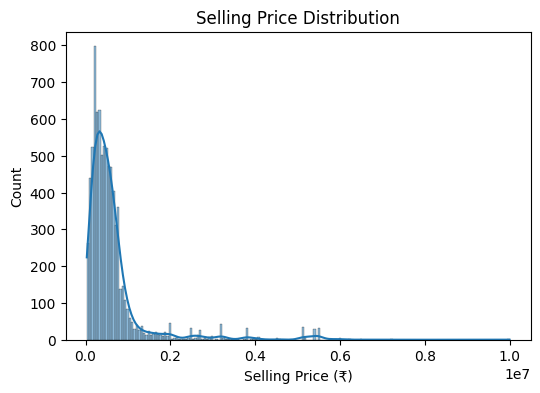

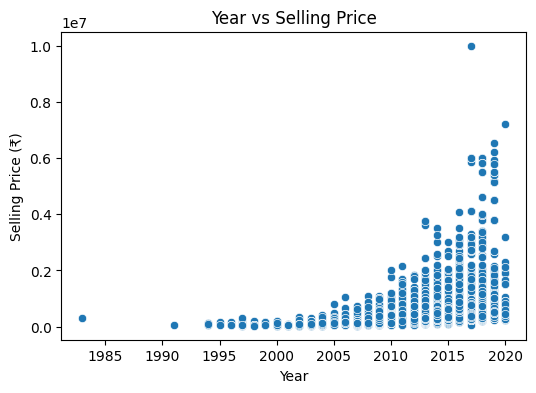

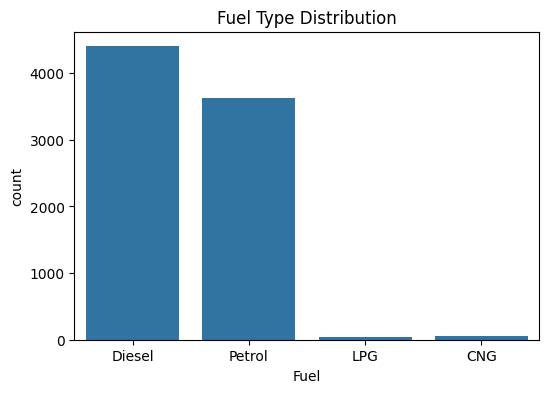

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary stats
print(df.describe(include='all'))
# Missing values
print(df.isnull().sum())

# Selling price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['selling_price'], kde=True)
plt.title('Selling Price Distribution')
plt.xlabel('Selling Price (₹)')
plt.show()

# Year vs Price scatter
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['year'], y=df['selling_price'])
plt.title('Year vs Selling Price')
plt.xlabel('Year')
plt.ylabel('Selling Price (₹)')
plt.show()

# Fuel type counts
plt.figure(figsize=(6,4))
sns.countplot(x=df['fuel'])
plt.title('Fuel Type Distribution')
plt.xlabel('Fuel')
plt.show()

# 3 Data Preprocessing & Feature Engineering

In [6]:
import numpy as np
import re
from sklearn.model_selection import train_test_split

# 1. Normalize column names
df.columns = df.columns.str.strip().str.lower()

# 2. Drop unused
df = df.drop(['name','torque'], axis=1, errors='ignore')

# 3. Parse numeric fields
df['mileage']   = df['mileage'].astype(str).str.split().str[0].astype(float)
df['engine']    = df['engine'].astype(str).str.split().str[0].astype(float)
def parse_power(x):
    m = re.match(r"([0-9]+\.?[0-9]*)", str(x))
    return float(m.group(1)) if m else np.nan

df['max_power'] = df['max_power'].apply(parse_power)

# 4. Fill missing
for col in ['mileage','engine','max_power','seats']:
    df[col] = df[col].fillna(df[col].median())

# 5. Feature: car age
CURRENT_YEAR = 2025
if 'year' in df.columns:
    df['car_age'] = CURRENT_YEAR - df['year']
    df = df.drop('year', axis=1)

# 6. One-hot encode categoricals
cats = ['fuel','seller_type','transmission','owner']
to_enc = [c for c in cats if c in df.columns]
if to_enc:
    df = pd.get_dummies(df, columns=to_enc, drop_first=True)

# 7. Split features/target
y = df['selling_price']
X = df.drop('selling_price', axis=1)

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4 Scale Numeric Features

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

numeric_cols = ['km_driven','mileage','engine','max_power','seats','car_age']
scaler = StandardScaler()

# Scale train
scaled_train = pd.DataFrame(
    scaler.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols,
    index=X_train.index
)
X_train_scaled = X_train.copy()
for col in numeric_cols:
    X_train_scaled[col] = scaled_train[col]

# Scale test
scaled_test = pd.DataFrame(
    scaler.transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
)
X_test_scaled = X_test.copy()
for col in numeric_cols:
    X_test_scaled[col] = scaled_test[col]

# 5 Train & Compare Models

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree'    : DecisionTreeRegressor(random_state=42),
    'Random Forest'    : RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost'          : XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = []
for name, m in models.items():
    m.fit(X_train_scaled, y_train)
    preds = m.predict(X_test_scaled)
    mse   = mean_squared_error(y_test, preds)
    results.append({
        'Model': name,
        'R2'   : r2_score(y_test, preds),
        'MAE'  : mean_absolute_error(y_test, preds),
        'RMSE' : mse**0.5
    })

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(results_df)

               Model        R2            MAE           RMSE
2      Random Forest  0.967868   70338.138105  145126.784176
3  Gradient Boosting  0.961366   92388.286484  159135.834305
4            XGBoost  0.960502   71587.726562  160904.368915
1      Decision Tree  0.944342   82327.057901  191004.800279
0  Linear Regression  0.697874  268886.595212  445015.467034


# 6 Hyperparameter Tuning

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

param_grid = {'n_estimators':[50,100,200], 'max_depth':[None,5,10]}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                    cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
print('Best params:', grid.best_params_)
print('Best CV R2:', grid.best_score_)

# Retrain final model
best = grid.best_params_
tuned = RandomForestRegressor(**best, random_state=42)
tuned.fit(X_train_scaled, y_train)
preds = tuned.predict(X_test_scaled)
mse_t = mean_squared_error(y_test, preds)
print('Test R2 :', r2_score(y_test,preds))
print('Test MAE:', mean_absolute_error(y_test,preds))
print('Test RMSE:', mse_t**0.5)

Best params: {'max_depth': None, 'n_estimators': 200}
Best CV R2: 0.9571906398515312
Test R2 : 0.9686443367477652
Test MAE: 69740.00614128115
Test RMSE: 143363.6961730842


# 7 Summarize Findings

**Best Model:** Random Forest Regressor (tuned)

- **Test R²:** 0.9686  
- **Test MAE:** ₹69,740.01  
- **Test RMSE:** ₹143,363.70  

**Most Influential Features:**  
1. `car_age` (age of the car)  
2. `km_driven` (total kilometers driven)  
3. `mileage` (fuel efficiency)  
4. `max_power` (engine power)  

**Next Steps:**  
1. Collect more data (e.g., car brand, location, optional features) to improve generalization.  
2. Experiment with advanced ensemble techniques (e.g., stacking or blending) to boost accuracy.  
3. Deploy the final model as a REST API or containerized app for production use.  
4. Monitor performance over time and periodically retrain with new data.

# 8 Save feature_names, rf_model & scaler

In [16]:
import pickle
# Must be run after the final X_train_scaled has all dummy columns

feature_names = X_train_scaled.columns.tolist()
with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
    
with open('../models/rf_model.pkl','wb') as f:
    pickle.dump(tuned, f)
    
with open('../models/scaler.pkl','wb') as f:
    pickle.dump(scaler, f)
    
print('Saved feature_names (count =', len(feature_names),'):')
print(feature_names)

Saved feature_names (count = 16 ):
['km_driven', 'mileage', 'engine', 'max_power', 'seats', 'car_age', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'transmission_Manual', 'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner']


# Conclusion

In this project, I have:

- **Ingested & inspected** raw data from CarDekho, handling missing values and data inconsistencies.
- Performed **Exploratory Data Analysis** to visualize price distributions, fuel type counts, and relationships between features.
- Executed **feature engineering**, converting raw strings into numeric fields and encoding categorical variables.
- Trained and compared multiple regression models, selecting a **tuned Random Forest** as the best based on Test R² of 0.9686, MAE of ₹69.7k, and RMSE of ₹143.4k.
- Developed an **interactive Streamlit app** to demonstrate real-time price predictions using the trained model.

This end-to-end workflow—from data ingestion to a deployable web demo—demonstrates my ability to build a complete machine learning solution. I documented all assumptions and challenges and identified next steps for future improvements.